# PCA over Faces

In [1]:
import numpy as  np 
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import os

plt.ion()
%matplotlib inline

In [6]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'num_classes':8,
    'val_split': 0.7
}

# Precomputed the mean for later use
Image_Mean = np.array([162.2261512169471, 120.73487454927884, 99.2227783203125])/256

In [7]:
# Load images

# Load Image using PIL for dataset
def load_image(path):
	im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
	im = im.resize((opt['image_size'],opt['image_size']))
	im = np.array(im)
	im = im/256
	return im

# Load the full data from directory
def load_data(dir_path):
	image_list = []
	y_list = []
	for filename in os.listdir(dir_path):
		if filename.endswith(".jpg"): 
			im = load_image(os.path.join(dir_path,filename))
			y = filename
			image_list.append(im)
			y_list.append(int(filename.split('_')[0]))
		else:
			continue

	image_list = np.array(image_list)
	y_list = np.array(y_list)

	print("Total Dataset shape:",image_list.shape)

	return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(y[i-1]))
        plt.axis('off')
    plt.show()

In [24]:
# Load the data
X,y = load_data('./dataset/')
N,W,H = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Total Dataset shape: (520, 32, 32)


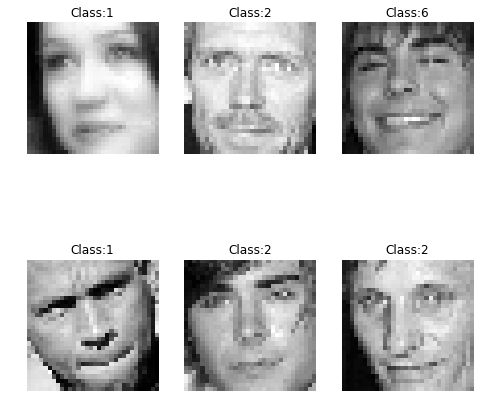

In [9]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

In [10]:
# Flatten to apply PCA
X = X.reshape((N,np.prod(X.shape[1:])))

In [11]:
def get_eigen_vectors(X):
    """
        Get the eigen vectors of the covariance matrix
        also sort them by eigen value
    """
    X_cov = np.cov(X.T)
    eig_val, eig_vec = np.linalg.eig(X_cov)
    sort_ind = np.argsort(eig_val)[::-1]
    eig_vec = eig_vec[sort_ind,:]
    return eig_vec

In [12]:
eig_vec = get_eigen_vectors(X)
eig_vec.shape

(1024, 1024)

In [13]:
def get_pca(X,eig_vec,k):
    """
        Get PCA of K dimension using the top eigen vectors 
        by eigen value
        Also return the reconstructed data using just the top K vectors
    """
    return np.real(X.dot(eig_vec[0:k,:].T)) , np.abs(X.dot(eig_vec[0:k,:].T.dot(eig_vec[0:k,:])))

# Display PCA for 1 2 3 D

In [14]:
X_1D,_ = get_pca(X,eig_vec,1)
X_2D,_ = get_pca(X,eig_vec,2)
X_3D,_ = get_pca(X,eig_vec,3)
X_32D,_ = get_pca(X,eig_vec,32)
X_64D,_ = get_pca(X,eig_vec,64)
# X_new = X_new.reshape((N,W,H,C))

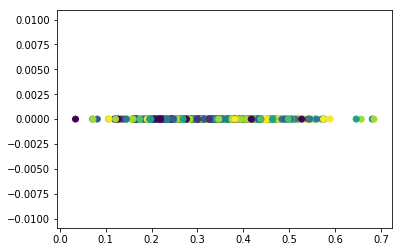

In [15]:
plt.scatter(X_1D,np.zeros(N),c=y)

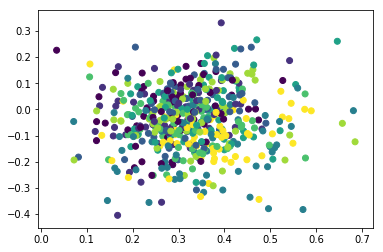

In [16]:
plt.scatter(X_2D[:,0],X_2D[:,1],c=y)

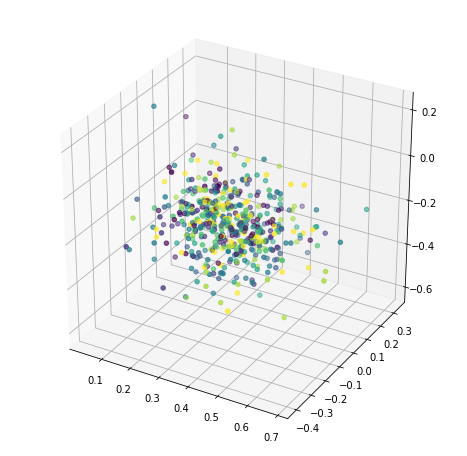

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)

# Plot the error from reconstruction of K dimension Image

Text(0.5,1,'Reconstruction Error(Avg:Per Pixel)')

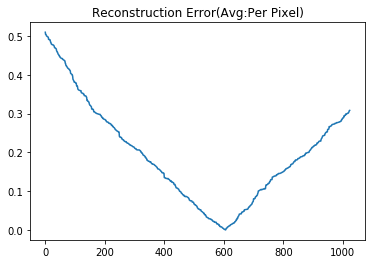

In [18]:
error_list = []
X = X.reshape((N,np.prod(X.shape[1:])))
for i in range(W*H):
    _,X_new = get_pca(X,eig_vec,i)
    error_val = np.mean((X - X_new)**2)
    error_list.append(np.abs(error_val))
    if i%100 == 0:
        print("Completed:",i)

plt.plot(error_list)
plt.title("Reconstruction Error(Avg:Per Pixel)")

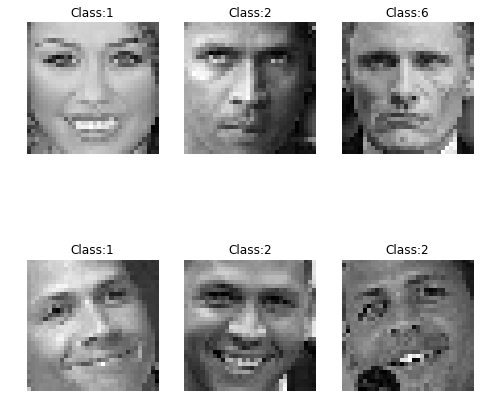

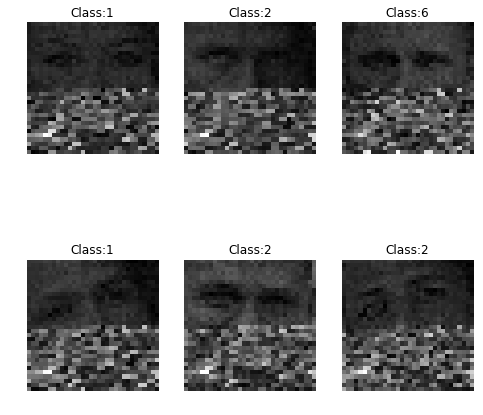

-0.2888501408228875

In [19]:
# Test to check if we get the original image back  
k = 1000
X = X.reshape((N,np.prod(X.shape[1:])))
_,X_new = get_pca(X,eig_vec,k)
X_new = np.squeeze(X_new.reshape((N,W,H,C)))
X = np.squeeze(X.reshape((N,W,H,C)))
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)
disply_images(X_new[ind,...],y[ind], row=2,col=3)
np.sum(X - X_new)/(N*W*H*C)

# Apperently No

 # Bayesian Classification

In [25]:
# Get the PCA of K=32 to solve
K = 32
X = X.reshape((N,np.prod(X.shape[1:])))
val_ind = int(opt['val_split']*X.shape[0])
X,_ = get_pca(X,eig_vec,K)

In [26]:
# Get the covariance matrix 
X_cov =  np.cov(X.T)

In [27]:
# Check which case do these statisfy
X_sub_cov_list = []
for clas in range(opt['num_classes']):
    X_subclass = X[y==clas]
    X_sub_cov = np.cov(X.T)
    X_sub_cov_list.append(X_sub_cov) 

X_sub_cov_list = np.array(X_sub_cov_list)
    
np.all(X_sub_cov_list == X_sub_cov_list[0,:], axis = (1,2))    


array([ True,  True,  True,  True,  True,  True,  True,  True])

## Training

In [28]:
# Hence They classify for class 2
# Get W,w,b => parameters for bayesian network for each class
X_sub_cov_inv = np.linalg.inv(X_sub_cov_list[0])
w_class = []
b_class =[]
for clas in range(opt['num_classes']):

    X_subclass = X[y==clas]
    X_sub_mean = X_subclass.mean(axis=0)
    prob = (X_subclass.shape[0]/N)
    
    w = X_sub_cov_inv.dot(X_sub_mean)
    w_class.append(w)
    b = np.log(prob) \
        -0.5*X_sub_mean.T.dot(X_sub_cov_inv).dot(X_sub_mean)
    b_class.append(b)

w_class = np.array(w_class)
b_class = np.array(b_class)   

# Testing 

In [29]:
# For each class get the g(t) or X.wi  + bi for each class
y_pred = X.dot(w_class.T) + b
y_pred = np.argmax(y_pred,axis=1)

# Accuracy
print("Bayesian Acc:",np.sum(y == y_pred)/N)

Bayesian Acc: 0.36346153846153845


In [39]:
# Load the data
X,y = load_data('./dataset/')
N,W,H = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Total Dataset shape: (520, 32, 32)


In [40]:
# Get the PCA of K=32 to solve
K = 32
X = X.reshape((N,np.prod(X.shape[1:])))
val_ind = int(opt['val_split']*X.shape[0])
X,_ = get_pca(X,eig_vec,K)

In [41]:
# Training and validation split
X_val = X[val_ind:N]
X = X[0:val_ind]
y_val = y[val_ind:N]
y = y[0:val_ind]
N = val_ind

# Linear Classifier using Softmax

Epoch:0 Loss:2.373137760418984 Acc:0.12087912087912088 Validation Acc:0.032692307692307694
Epoch:200 Loss:1.940684012542933 Acc:0.46153846153846156 Validation Acc:0.125
Epoch:400 Loss:1.9042405887423128 Acc:0.5274725274725275 Validation Acc:0.14423076923076922
Epoch:600 Loss:1.8854641843266988 Acc:0.5824175824175825 Validation Acc:0.1423076923076923
Epoch:800 Loss:1.873321613400747 Acc:0.5989010989010989 Validation Acc:0.13653846153846153
Epoch:1000 Loss:1.8647394077350121 Acc:0.5989010989010989 Validation Acc:0.12884615384615383
Epoch:1200 Loss:1.8584588247707123 Acc:0.6043956043956044 Validation Acc:0.13076923076923078
Epoch:1400 Loss:1.853843524922093 Acc:0.6043956043956044 Validation Acc:0.12115384615384615
Epoch:1600 Loss:1.8505377115754813 Acc:0.5961538461538461 Validation Acc:0.12115384615384615
Epoch:1800 Loss:1.821327053184188 Acc:0.5961538461538461 Validation Acc:0.12115384615384615
Epoch:2000 Loss:1.821327053184188 Acc:0.5961538461538461 Validation Acc:0.12115384615384615
Ep

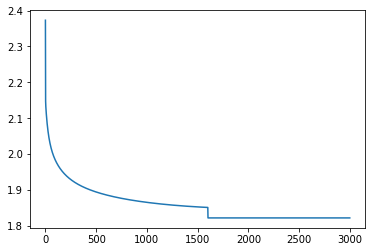

In [60]:
# Params
W = np.random.random((K,opt['num_classes']))
b = np.zeros(opt['num_classes'])
# Hyper Params
lr = 0.001
reg = 0.001
epochs = 3000
print_iter = 200
decay_iter = 1500
# Loss Variables
prev_loss = 0
loss_hist = []
acc_hist = []
val_acc_hist = []


y_gtr = np.zeros((N,opt['num_classes']))
y_gtr[np.arange(0,N), y] = 1
for epoch in range(epochs):
    
    # Forward prop
    y_pred = X.dot(W) + b
    softmax = np.exp(y_pred)/np.sum(np.exp(y_pred),axis=1)[:, np.newaxis]
    loss = -np.mean(np.log(softmax[np.arange(0,N), y])) + 0.5*reg*np.sum(W*W)

    loss_hist.append(loss)


    # Backprop
    dL = y_pred.copy()
    dL[np.arange(0,N), y] -= 1
    # dW for weights
    dW = X.T.dot(dL)
    W -= lr*dW
    W += reg*W

    if epoch % print_iter == 0:
        acc = np.sum(np.argmax(y_pred,axis=1) == y)/N
        val_y = X_val.dot(W) + b
        acc_val = np.sum(np.argmax(val_y,axis=1) == y_val)/520

        print("Epoch:{} Loss:{} Acc:{} Validation Acc:{}".format(epoch,loss,acc,acc_val))
        
        acc_hist.append(acc)
        val_acc_hist.append(acc_val)
        if epoch > decay_iter:
            lr = lr//2
            reg = 4*reg//5
        
    prev_loss = loss

plt.plot(loss_hist)

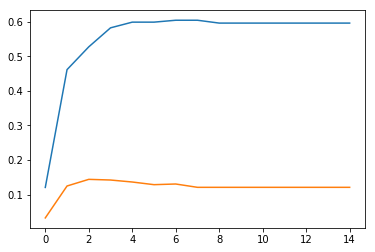

In [61]:
plt.plot(acc_hist)
plt.plot(val_acc_hist)